In [1]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam
from backtester.swarms import SwarmManager, SwarmRanker

import pandas as pd
import numpy as np
import scipy
from scipy.io import loadmat, savemat

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


## Script settings

In [46]:
# File name of exo strategy
EXO_File = 'strategy_270225'


#
# Costs settings
#
costs_options = 3.0 # 3$ per side per option contract
costs_futures = 3.0 # 3$ per side per futures contract



#
# Swarm settings
#

# number of strategies to pick  from the swarm
NSwarm_Members = 5

#
# Swarm generation parameters
#  MA Cross periods and Trailing stop size
STRATEGY_PARAMS = [
            #OptParam(name, default_value, min_value, max_value, step)
            OptParam('sphTreshold', 2, 1, 20, 2),
            OptParam('splTreshold', 2, 1, 20, 2),
            OptParam('RulesIndex', 0, 0 , 4, 1),
            OptParam('MedianPeriod', 5, 5, 20, 3)
    
        ]


STRATEGY_DIRECTION = -1

#
# Swingpoint global filter settings
#

# As a multiplier of volatility
up_factor = 3.0
down_factor = 10.0


## Exo data

In [47]:
strategyname_global = EXO_File
d, info = matlab.loaddata('../mat/'+strategyname_global+'.mat')

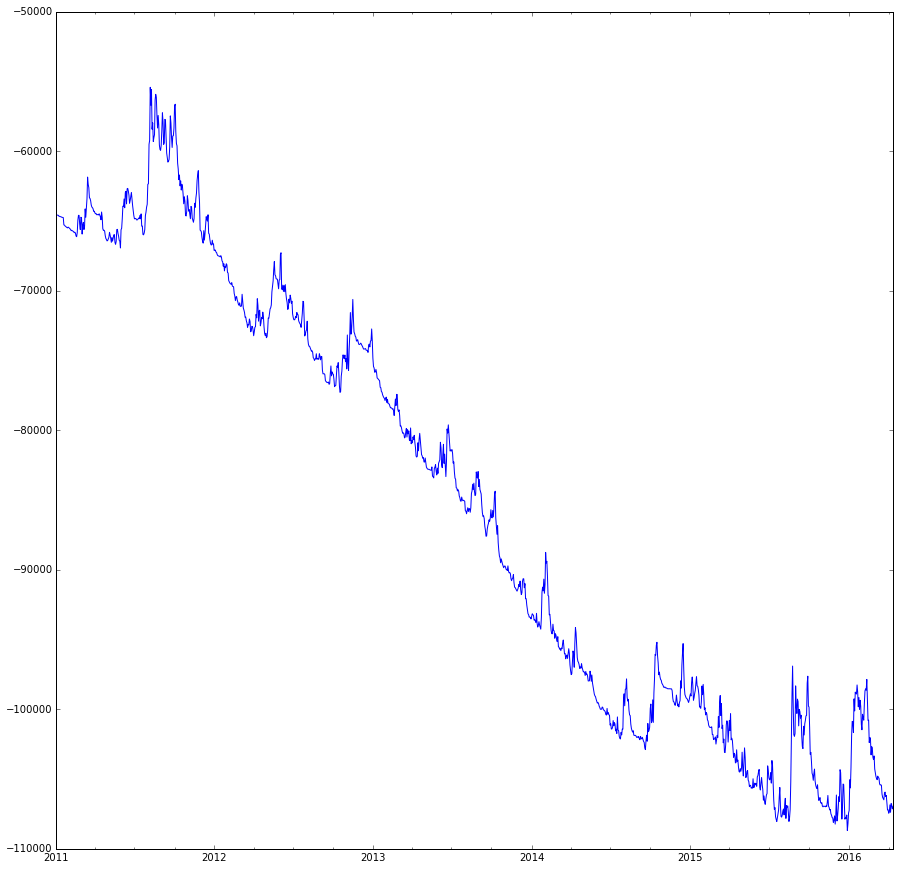

In [48]:
d.exo.plot()


In [49]:
info

{'legs': 4,
 'margin': 3850,
 'name': 'BearishCollarBrokenWing',
 'pcf': array([1, 2, 0, 1], dtype=uint8),
 'pcfqty': array([-1, -1,  1,  1], dtype=int16),
 'tickincrement': 0.25,
 'tickvalue': 12.5,
 'underlying': 'EP'}

### Swing points function

In [50]:
mat_file = loadmat('../mat/'+strategyname_global+'.mat')
def SwingPoints(sphThreshold, splThreshold, prices_index, mat_file):
    
    '''
    !Required for mat file loading! from scipy.io import loadmat, savemat 
    
    sphTreshold - int number of days from breakout
    splTreshold - int number of days from breakout
    prices_index - pd series of exo prices index
    mat_file - .mat file like - mat_file = loadmat('../mat/'+strategyname_global+'.mat')
    
    returns -> df with sphLevel/volume and splLevel/volume pd series with exo prices index. 
                Plus VolumeSeries and price with exo prices index
    '''
    
    mat = mat_file ############## Temp! Path must be an argument

    signalArray = mat['optStr']['entrySignalingSeries'][0][0]
    volumeArray = mat['optStr']['volumeSeries'][0][0][0]

    OPEN  = 0; HIGH  = 1; LOW   = 2;  CLOSE = 3;

    if len(signalArray) == 1:
        OPEN  = HIGH  = LOW = CLOSE = 0

    currentHigh  = -np.inf #intmin('int32');
    currentLow   = np.inf #intmax('int32');

    currentHVol  = 0
    currentLVol  = 0
    sphDays      = 0
    splDays      = 0
    sphStart     = 1
    splStart     = 1
    sphMaxDay    = 0
    splMinDay    = 0
    prevHigh     = signalArray[HIGH][0]
    prevLow      = signalArray[LOW][0]
    prevHVol     = volumeArray[0]
    prevLVol     = volumeArray[0]


    nDays        = len(signalArray[CLOSE])

    sphIndicator = np.zeros(nDays)
    splIndicator = np.zeros(nDays)

    sphLevel = np.zeros(nDays)
    splLevel = np.zeros(nDays)

    sphVolume = np.zeros(nDays)
    splVolume = np.zeros(nDays)

    for dday in range(nDays):

        if signalArray[HIGH][dday] > currentHigh:
            currentHigh = signalArray[HIGH][dday]
            currentHVol = volumeArray[dday]
            sphMaxDay   = dday;
            sphDays     = 0
        else:
            sphDays = sphDays+1;

        if signalArray[LOW][dday] < currentLow:
            currentLow = signalArray[LOW][dday]
            currentLVol = volumeArray[dday]
            splMinDay  = dday
            splDays    = 0
        else:
            splDays = splDays+1;



        if sphDays > sphThreshold:
            sphLevel[dday] = currentHigh;
            sphIndicator[dday] = 1;
            sphVolume[dday] = currentHVol;

            for dd in range(sphStart, dday): #?? or dday-1
                sphLevel[dd] = prevHigh
                sphVolume[dd]= prevHVol

            prevHigh = currentHigh
            prevHVol = currentHVol
            sphStart = dday
            sphDays = 0    
            currentHigh = -np.inf #intmin('int32');

        elif dday > 1:
            sphVolume[dday] = sphVolume[dday-1]
        elif dday == 1:
            sphVolume[dday] = volumeArray[dday]




        if splDays > splThreshold:
            splLevel[dday] = currentLow;
            splIndicator[dday] = 1;
            splVolume[dday] = currentLVol;

            for dd in range(splStart, dday):  #??? or dday-1 
                splLevel[dd] = prevLow
                splVolume[dd] = prevLVol

            prevLow = currentLow
            prevLVol = currentLVol
            splStart = dday
            splDays = 0
            currentLow =  np.inf #intmax('int32');
        elif dday > 1:
            splVolume[dday] = splVolume[dday-1]
        elif dday == 1:
            splVolume[dday] = volumeArray[dday]

        # fill to the end
        for dd in range(sphStart, nDays):
            sphLevel[dd] = prevHigh;
            sphVolume[dd] = prevHVol;

        for dd in range(splStart, nDays):
            splLevel[dd] = prevLow;
            splVolume[dd] = prevLVol;
            
    return pd.DataFrame({'sphLevel' : pd.Series(sphLevel, index=prices_index),'splLevel' : pd.Series(splLevel, index=prices_index), 
            'sphVolume': pd.Series(sphVolume, index=prices_index), 'splVolume': pd.Series(splVolume, index=prices_index), 
            'volumeSeries': pd.Series(volumeArray, index=prices_index), 
            'price': pd.Series(mat['optStr']['entrySignalingSeries'][0][0][3], index=d.exo.index)}, index=prices_index)

In [51]:
# Df test
sp_df = SwingPoints(8, 8, d.exo.index, mat_file)

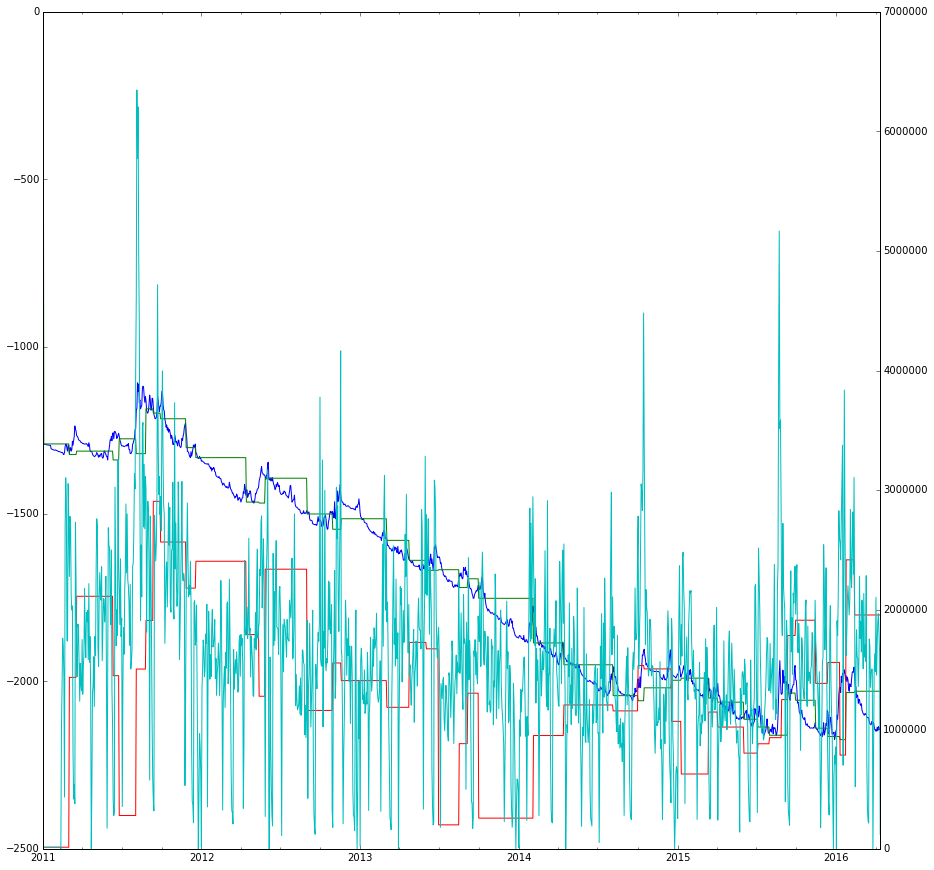

In [52]:
figsize(15, 15)
sp_df.price.plot()
sp_df.splLevel.plot()
sp_df.splVolume.plot(secondary_y=True)
sp_df.volumeSeries.plot(secondary_y=True)

# Class based strategy

In [53]:
class StrategySwingPointsTrail(StrategyBase):
    def __init__(self):
        # Initialize parent class
        super().__init__()
        
        # Define system's name
        self.name = 'Swing points breakouts with trailing stop'
        
        # This is a short strategy
        self.direction = STRATEGY_DIRECTION
        
        # Define optimized params
        self.opts = STRATEGY_PARAMS
        
        self.initialize()
        
    def initialize(self):
        #
        #  Loading EXO quotes from .mat file
        #
        strategyname = strategyname_global
        self.data, info = matlab.loaddata('../mat/'+strategyname+'.mat')
        
        #
        # Estimating transaction costs in base points of price
        #
        
        # No costs
        self.costs = pd.Series(0, self.data.index)
        
        # Flat costs / 1 point of EXO price per side / 2 roundtrip
        #self.costs = pd.Series(12.0, self.data.index)
        
        # Dynamic costs (we could utilize dynamic costs models)
        #  Like slippage calculation on bid/ask data / etc
        # Some meta code (just in my imagination)
        # costmanager = CostManager('EXO.Ticker').LoadSlippageFromDB('2000-01-01', now)
        # self.costs = costmanager.getslippage() + pd.Series(0.1, self.data.index) # Slippage + commission
    
    @property
    def positionsize(self):
        """
        Returns volatility adjuster positions size for strategy
        :return:
        """
            
        # Defining EXO price
        px = self.data.exo
        
        #Test !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        return pd.Series(1.0, index=px.index)

        # Calculate position size adjusted to volatility of EXO
        # Dollar risk per 1 volatility unit
        risk_perunit = 100
        risk_vola_period = 100

        # Calculate volatility unit
        # In this case we use 10-period rolling median of EXO changes
        vola = abs(px.diff()).rolling(risk_vola_period).median()
        # We want to risk 100$ per 1 volatility unit
        #
        # This type of position sizing used for calibration of swarm members
        # After swarm generation and picking we will use portfolio based MM by Van Tharp
        # Tailored for portfolio size and risks of particular client
        return risk_perunit / vola
    
    def calculate(self, params=None):
        #        
        #  On every iteration of swarming algorithm, parameter set will be different.
        #  For more information look inside: /notebooks/tmp/Swarming engine research.ipynb
        #       
        
        if params is None:
            # Return default parameters
            sphTreshold_value, splTreshold_value, rules_index, period_median = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            sphTreshold_value, splTreshold_value, rules_index, period_median = params
        
        # Defining EXO price
        px = self.data.exo
        
        #
        #
        # Swing poins rules calculation
        #
        #
        '''     
        testHPrice = optStr.entrySignalingSeries(CLOSE,dd);   Note OPEN=1, HIGH=2, LOW=3, CLOSE=4
        testLPrice = optStr.entrySignalingSeries(CLOSE,dd);

        longSignalPrice      = sphLevel(dd-1);    % swing point high value on the previous day
        shortSignalPrice     = splLevel(dd-1);    % swing point low value on the previous day

        optStr.sphVolume     = the volume on the last swing-point-high day
        optStr.splVolume     = the volume on the last swing-point-low  day
        '''
        epsilon = 1.0000e-012
        
        # Setting Swing point DF
        sp_df = SwingPoints(sphTreshold_value, splTreshold_value, d.exo.index, mat_file)
        
        
        '''
        Bullish Breakout Confirmed 
        --------------------------
        not in position
        &&
        testHPrice > longSignalPrice , i.e. testHPrice - longSignalPrice >= EPSILON
        &&
        optStr.volumeSeries(dd) > optStr.sphVolume(dd-1)
        '''
        bullish_breakout_confirmed = (sp_df.price > sp_df.sphLevel.shift(1)) & ((sp_df.price - sp_df.sphLevel.shift(1)) >= epsilon) & (sp_df.volumeSeries > sp_df.sphVolume.shift(1))
        
            
        '''
        Bullish Breakout Suspected
        --------------------------
        not in position
        &&
        testHPrice > longSignalPrice , i.e. testHPrice - longSignalPrice >= EPSILON
        &&
        optStr.volumeSeries(dd) <= optStr.sphVolume(dd-1)
        '''
        # Without volume Confirmed and Suspected are the same rules
        bullish_breakout_suspected = (sp_df.price > sp_df.sphLevel.shift(1)) & ((sp_df.price - sp_df.sphLevel.shift(1)) >= epsilon) & (sp_df.volumeSeries > sp_df.sphVolume.shift(1))
        
        '''
        Bearish Breakout Confirmed 
        --------------------------
        not in position
        &&
        testLPrice < shortSignalPrice , i.e. testLPrice - shortSignalPrice <= -EPSILON
        &&
        optStr.volumeSeries(dd) > optStr.splVolume(dd-1)
        '''
        bearish_breakout_confirmed = (sp_df.price < sp_df.splLevel.shift(1)) & ((sp_df.price - sp_df.splLevel.shift(1)) <= -epsilon) & (sp_df.volumeSeries > sp_df.splVolume.shift(1))            
          
        
            
        '''
        Bearish Breakout Suspected
        --------------------------
        not in position
        &&
        testLPrice < shortSignalPrice , i.e. testLPrice - shortSignalPrice <= -EPSILON
        &&
        optStr.volumeSeries(dd) <= optStr.splVolume(dd-1)
        '''
        # Without volume Confirmed and Suspected are the same rules
        bearish_breakout_suspected = (sp_df.price < sp_df.splLevel.shift(1)) & ((sp_df.price - sp_df.splLevel.shift(1)) <= -epsilon) & (sp_df.volumeSeries <= sp_df.splVolume.shift(1))            
        
        # Days after breakout calc
        ##
        ## Bullish
        ##
        confirmationTimeThreshold = 0 # Days after breakout
        temp_a = np.zeros(len(sp_df))
        bullish_breakout_confirmed_prev = bullish_breakout_confirmed.shift(1)
        for i in range(len(sp_df)):
            if bullish_breakout_confirmed_prev[i] == 1 and bullish_breakout_confirmed[i] == 0 :
                confirmationTimeThreshold = confirmationTimeThreshold + 1 
            elif bullish_breakout_confirmed[i] == 0:
                confirmationTimeThreshold = confirmationTimeThreshold + 1 
            elif bullish_breakout_confirmed[i] == 1:
                confirmationTimeThreshold = 0
            temp_a[i] = confirmationTimeThreshold
        sp_df['confirmationTimeThresholdBullish'] = pd.Series(temp_a, index=sp_df.index)
        ##
        ## Bearish
        ##
        confirmationTimeThreshold = 0 # Days after breakout
        temp_a = np.zeros(len(sp_df))
        bearish_breakout_confirmed_prev = bearish_breakout_confirmed.shift(1)
        for i in range(len(sp_df)):
            if bearish_breakout_confirmed_prev[i] == 1 and bearish_breakout_confirmed[i] == 0:
                confirmationTimeThreshold = confirmationTimeThreshold + 1 
            elif bearish_breakout_confirmed[i] == 0:
                confirmationTimeThreshold = confirmationTimeThreshold + 1 
            elif bearish_breakout_confirmed[i] == 1:
                confirmationTimeThreshold = 0
            temp_a[i] = confirmationTimeThreshold
        sp_df['confirmationTimeThresholdBearish'] = pd.Series(temp_a, index=sp_df.index)
        
        # Failure flags calc
        ##
        ## Bullish
        ##
        bullish_failureflag = 0
        failureLongLine = sp_df.price.shift(1)
        longPenetrationCount = 0
        temp_a = np.zeros(len(sp_df))
        for i in range(len(sp_df)):
            if (sp_df.price[i] < failureLongLine[i]) & (longPenetrationCount <= sp_df.confirmationTimeThresholdBullish[i]):
                bullish_failureflag = 1
            elif (longPenetrationCount > sp_df.confirmationTimeThresholdBullish[i]):
                bullish_failureflag = 0
            else:
                longPenetrationCount = longPenetrationCount + 1
            temp_a[i] = bullish_failureflag
        sp_df['bullish_failureflag'] = pd.Series(temp_a, index=sp_df.index)   
        ##
        ## Bearish
        ##
        bearish_failureflag = 0
        failureShortLine = sp_df.price.shift(1)
        shortPenetrationCount = 0
        temp_a = np.zeros(len(sp_df))
        for i in range(len(sp_df)):
            if (sp_df.price[i] > failureShortLine[i]) & (shortPenetrationCount <= sp_df.confirmationTimeThresholdBearish[i]):
                bearish_failureflag = 1
            elif (shortPenetrationCount > sp_df.confirmationTimeThresholdBearish[i]):

                bearish_failureflag = 0
            else:
                shortPenetrationCount = shortPenetrationCount + 1
            temp_a[i] = bearish_failureflag
        sp_df['bearish_failureflag'] = pd.Series(temp_a, index=sp_df.index)   
        
        '''
        Bullish Failure Confirmed
        ------------------------
        not in position
        &&
        if testHPrice > longSignalPrice , i.e. testHPrice - longSignalPrice >= EPSILON
        &&
        optStr.volumeSeries(dd) > optStr.sphVolume(dd-1)
        {
             set the failure flag 
             reset the longPenetrationCount = 0 
             set the failure line to the previous day close:
                  failureLongLine = optStr.entrySignalingSeries(CLOSE,max(dd-1,1))
        }


        if failure flag, for the next  "confirmationTimeThreshold" days do the following
        {
           if testHPrice < failureLongLine && longPenetrationCount <= confirmationTimeThreshold
            we have failure signal
           else
            increment longPenetrationCount
            if longPenetrationCount > confirmationTimeThreshold
               reset the failure flag as the failure setup expired
                end
           end
        }
        '''    
        bullish_failure_confirmed = (bullish_breakout_confirmed == 1) & (sp_df.bullish_failureflag == 1) & (sp_df.volumeSeries > sp_df.sphVolume.shift(1))
        
        bullish_failure_suspected = (bullish_breakout_confirmed == 1) & (sp_df.bullish_failureflag == 1) & (sp_df.volumeSeries <= sp_df.sphVolume.shift(1))
        '''
        Bearish Failure Confirmed
        -------------------------
        not in position
        &&
        testLPrice < shortSignalPrice , i.e. testLPrice - shortSignalPrice <= -EPSILON
        &&
        optStr.volumeSeries(dd) > optStr.splVolume(dd-1)
        {
             set the failure flag
             reset the shortPenetrationCount = 0 
             set the failure line to the previous day close:
                  failureShortLine= optStr.entrySignalingSeries(CLOSE,max(dd-1,1))
        }

        if failure flag is set, for the next  "confirmationTimeThreshold" days do the following
        {
             if testLPrice > failureShortLine && shortPenetrationCount <= confirmationTimeThreshold
            we have failure signal
           else
            increment shortPenetrationCount
            if shortPenetrationCount > confirmationTimeThreshold
               reset the failure flag as the failure setup expired
                end
           end
        }
        '''
        bearish_failure_confirmed = (bearish_breakout_confirmed == 1) & (sp_df.bearish_failureflag == 1) & (sp_df.volumeSeries > sp_df.splVolume.shift(1))
        
        bearish_failure_suspected = (bearish_breakout_confirmed == 1) & (sp_df.bearish_failureflag == 1) & (sp_df.volumeSeries <= sp_df.splVolume.shift(1))
        
        if self.direction == 1:     
            rules_list = [bullish_breakout_confirmed, bullish_failure_confirmed, bullish_breakout_suspected, bullish_failure_suspected]
            
        elif self.direction == -1:
            rules_list = [bearish_breakout_confirmed, bearish_failure_confirmed, bearish_breakout_suspected, bearish_failure_suspected]    
        

        # Median based trailing stop
        trailing_stop = px.rolling(period_median).median().shift(1)        
    
        # Enry/exit rules
        entry_rule = rules_list[rules_index]
        
        if self.direction == 1:     
            exit_rule = (CrossDown(px, trailing_stop)) # Cross down for longs
            
        elif self.direction == -1:
            exit_rule = (CrossUp(px, trailing_stop)) # Cross up for shorts, Cross down for longs
        
        # Swarm_member_name must be *unique* for every swarm member
        # We use params values for uniqueness 
        swarm_member_name = str((sphTreshold_value, splTreshold_value, rules_index, period_median))        
        
        return swarm_member_name, entry_rule, exit_rule
        

<h1>Backtest results</h2>

In [54]:
# Initiate the strategy

strategy = StrategySwingPointsTrail()

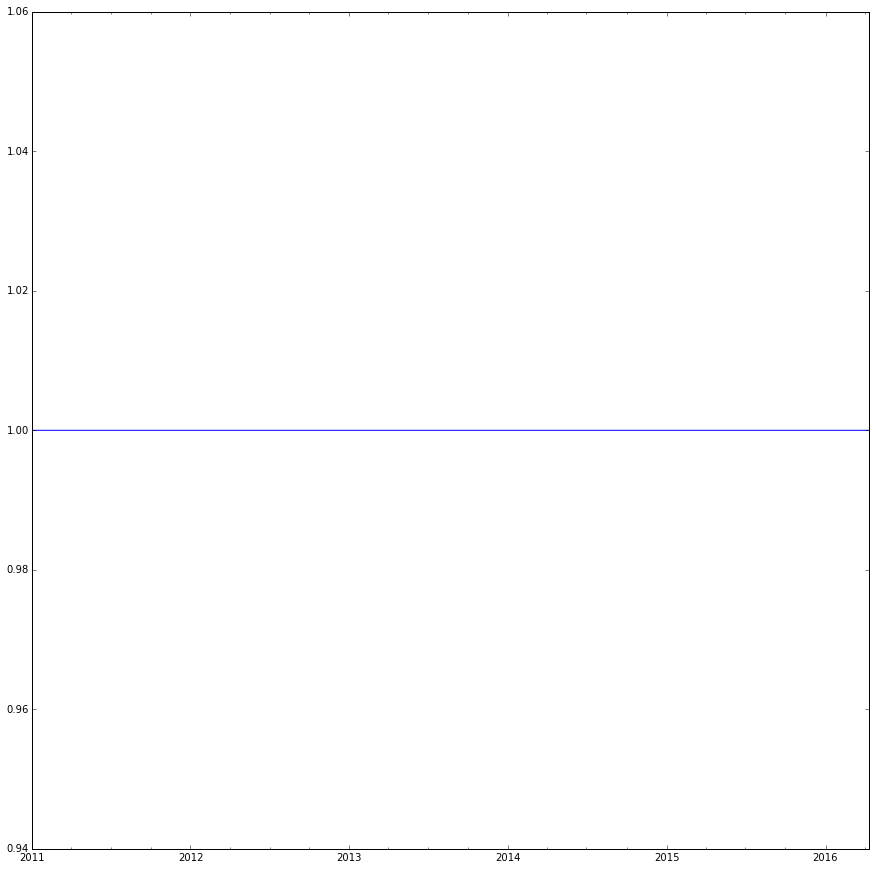

In [55]:
strategy.positionsize.plot()

In [56]:
# Running all parameters permutations in swarm
swarm, swarm_stats, swarm_inposition = strategy.run_swarm()

KeyboardInterrupt: 

In [ ]:
len(swarm)

# Analyze the swarm

### Exploriong swarm bounds

In [ ]:
figsize(15,10)
title(strategy.name)
swarm.apply(lambda x: np.percentile(x, q=95), axis=1).plot(label='Top 5%', c='g')
swarm.apply(lambda x: np.percentile(x, q=66), axis=1).plot(label='Top 66%', c='g', style='k--')
swarm.apply(np.median, axis=1).plot(label='Median member')
swarm.apply(lambda x: np.percentile(x, q=33), axis=1).plot(label='Bottom 33%', c='r', style='k--')
swarm.apply(lambda x: np.percentile(x, q=5), axis=1).plot(label='Bottom 5%', c='r')

legend(loc=2);

avg_no_costs = swarm.apply(np.mean, axis=1)

## Picking the swarm members and compose a portfolio


In [ ]:
# Swarm Manager context (settings)
context = {
    'nsystems': NSwarm_Members, # Number of swarm members to pick
}

# Rebalance the swarm every Monday
rebalance_time = swarm.index.dayofweek == 0

# Rank systems by 14 days returns of equity
# FYI: ranking_func must me assigned without () at the end of line!
ranking_func =  SwarmRanker.highestreturns_14days

### Setting up SwarmManager

In [ ]:
swarm_manager = SwarmManager(rebalancetime=rebalance_time,    # Every week
                             rankerfunc=ranking_func,         # Rank - 14 days returns
                             context=context,                 # Backtester settings / params
                            )

In [ ]:
# Getting average swarm member equity
avg_swarm = SwarmManager.get_average_swarm(swarm)

### Swarm global filtering algorithms



In [ ]:
price = avg_swarm
period = 10
vola_offset = 1.0

In [ ]:

def swingpoint_filter_threshold(price, period, up_factor, down_factor):
    #vola = price.diff(period=1).abs().rolling(60).median()
    vola = price.diff(period=5).abs().rolling(60).median()
    
    
    swing_point = pd.Series(np.nan, index=price.index)
    swing_point_regime = pd.Series(0, index=price.index)
    
    # Swing point bullish regime
    swing_switch = 1
    
    # Swing point start index
    sw_i = -1
    
    # Min/Max prices for swings
    sw_h_max = price[0]
    sw_l_min = price[0]
    
    
    for i in range(len(price)):
        if i == 0:
            continue
        if np.isnan(price[i]):
            continue
        if np.isnan(vola.values[i]):            
            continue
        elif sw_i == -1 and vola.values[i] > 0:     
            sw_h_max = sw_l_min = price[i]
            sw_i = i
        
        
        if swing_switch == 1:
            #
            #  We have a bullish swing 
            #
            sw_h_max = max(sw_h_max, price[i])
            
            
            # Check for reversion
            if price[i] <= sw_h_max-vola[sw_i]*down_factor:
                # Reverse swing
                swing_switch = -1
                sw_l_min = price.values[i]
                sw_h_max = price.values[i]
                swing_point.values[i] = sw_l_min + vola[sw_i]*up_factor
                
                sw_i = i
            else:
                swing_point.values[i] = sw_h_max-vola[sw_i]*down_factor  
                
                
        else:
            #
            #  We have a bearish swing
            #
            sw_l_min = min(sw_l_min, price.values[i])
            
            
            # Check for reversion
            if price.values[i] >= sw_l_min + vola[sw_i]*up_factor:
                # Reverse swing
                swing_switch = 1
                sw_l_min = price.values[i]
                sw_h_max = price.values[i]
                sw_i = i
                swing_point.values[i] = sw_h_max - vola[sw_i]*down_factor                  
            else:
                swing_point.values[i] = sw_l_min + vola[sw_i]*up_factor  
                
        swing_point_regime.values[i] = swing_switch                
    return swing_point, swing_point_regime
            
            
swing_point_threshold, swing_point_regime_threshold = swingpoint_filter_threshold(price, period, up_factor, down_factor)

price.plot()
swing_point_threshold.plot()
figure()

swing_point_regime_threshold.plot.area(stacked=False)    
    

### Applying global swingpoint factor

In [ ]:
# Simple swing point filter
#global_filter = swing_point_regime == -1


# Swing point filter with volatility threshold
global_filter = swing_point_regime_threshold == -1



In [ ]:
is_picked_df_no_filter = swarm_manager.backtest(swarm)
is_picked_df_with_filter = swarm_manager.backtest(swarm, global_filter)

# Estimating swarm rebalance and global_filter costs

In [ ]:
swarm_picked_inposition_wfilter  = swarm_inposition & is_picked_df_with_filter
swarm_picked_inposition_wofilter  = swarm_inposition & is_picked_df_no_filter


## Transaction count for swarm (in + outs) * swarm_members

In [ ]:
swarm_picked_inposition_wfilter.sum().sum()

In [ ]:
swarm_picked_inposition_wofilter.sum().sum()

### Calculating costs for swarm

In [ ]:
def calc_costs_per_side(exo_info, options_costs, futures_costs):
    """
    Calculates costs per one EXO unit
    """
    pcf = exo_info['pcf']
    pcfqty = exo_info['pcfqty']
    
    costs = 0.0
    
    for i, c in enumerate(pcf):
        if c == 2: # Futures contract
            costs += abs(pcfqty[i] * futures_costs)
        elif c == 0: # Call contract
            costs += abs(pcfqty[i] * options_costs)
        elif c == 1: # Put contract
            costs += abs(pcfqty[i] * options_costs)
        else:
            #Unexpected error
            raise ValueError("Unexpected contact type: {0}".format(c))        
        
    return costs

In [ ]:
swarm_transactions_wfilter = (swarm_picked_inposition_wfilter != swarm_picked_inposition_wfilter.shift()).astype(np.int8)
swarm_entries_wfilter = ( (swarm_picked_inposition_wfilter == 1) & (swarm_picked_inposition_wfilter.shift() == 0))

swarm_transactions_wofilter = (swarm_picked_inposition_wofilter != swarm_picked_inposition_wofilter.shift()).astype(np.int8)
swarm_entries_wofilter = ( (swarm_picked_inposition_wofilter == 1) & (swarm_picked_inposition_wofilter.shift() == 0))


costs = calc_costs_per_side(info, costs_options, costs_futures)

print('Estimated costs ${0}'.format(costs))
info

In [ ]:
swarm.columns

### Prepearing swarm data with rebalancing costs

In [ ]:
eq_changes_wfilter = swarm.diff()
eq_changes_wofilter = swarm.diff()



# Fixin costs and 1st bar bug
eq_changes_wfilter[swarm_entries_wfilter == 1] = 0
eq_changes_wofilter[swarm_entries_wofilter == 1] = 0




# Applying costs
eq_changes_wfilter[swarm_transactions_wfilter == 1] = -costs
eq_changes_wofilter[swarm_transactions_wofilter == 1] = -costs


figsize(20, 20)


avg_picked_equity_no_filter = eq_changes_wofilter[is_picked_df_no_filter == 1.0].mean(axis=1).cumsum().ffill()
avg_picked_equity_with_filter = eq_changes_wfilter[is_picked_df_with_filter == 1.0].mean(axis=1).cumsum().ffill()

#avg_all_equity = avg_swarm
avg_all_equity = swarm.diff().mean(axis=1).cumsum().ffill()



avg_all_equity.plot(label='Avg Swarm equity');
avg_picked_equity_no_filter.plot(label='Picked Swarm equity NO Filter')
avg_picked_equity_with_filter.plot(label='Picked Swarm equity WITH Filter')
#avg_swarm.rolling(100).mean().plot(label='Avg Swarm MovingAvg filter')
#swing_point.plot(label='SwingPoint')
title('Average swarm member equity');
legend(loc=2)

## Margin graphs

### Margin without global filter

In [ ]:
figsize(10, 10)
mrg = (swarm_picked_inposition_wofilter * info['margin']).sum(axis=1)

mrg.rolling(20).mean().plot(label="Mean Margin")
mrg.rolling(20).max().plot(label="Mean Margin")

### Margin with global filter

In [ ]:
figsize(10, 10)
mrg = (swarm_picked_inposition_wfilter * info['margin']).sum(axis=1)

mrg.rolling(20).mean().plot(label="Mean Margin")
mrg.rolling(20).max().plot(label="Mean Margin")